In [1]:
import os
import torch
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchtext.data.metrics import bleu_score

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
TRAIN_RATIO = 0.7
TEST_RATIO = 0.15
VAL_RATIO = 0.15

BATCH_SIZE = 16
WORKERS = 4
LEARNING_RATE=0.01
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 3
EPOCHS = 90


In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN

        resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)
        modules = list(resnet101.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(2048, embed_size),
            nn.ReLU(),
            nn.Dropout(p=0.5)
        )
        self.batchnorm = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.fine_tune()

    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out
    
    def fine_tune(self, fine_tune=True):

        for p in self.resnet.parameters():
            p.requires_grad = False
        print(len(list(self.resnet.children())))
        for c in list(self.resnet.children())[6:]:
            for p in c.parameters():
                p.requires_grad = fine_tune




In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=40):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.4)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


In [6]:
class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size).to(device)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs
    
    def caption_image(self, image, vocabulary, max_length=25):
        result_caption = []
        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0) # so that we have a dimention for batch
            states = None
            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x,states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1) # take the word with the highest probability

                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
                
        return [vocabulary.itos[idx] for idx in result_caption]

In [7]:
def custom_tokenizer(text):
    patterns = [
        r"\w+",
        r"\d+", 
        r"\S+" 
    ]
    pattern = "|".join(patterns)
    
    # Use the regex pattern to tokenize the text
    tokens = re.findall(pattern, text)
    
    tokens = [token.lower() for token in tokens]
    
    return tokens


In [8]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold # Minimum frequency for a word to be included in the vocabulary

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.lower() for tok in custom_tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]
    
    def caption_len(self,text):
        tokenized_text = self.tokenizer_eng(text)
        return len(tokenized_text)
    

class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=3):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        caplen = self.vocab.caption_len(caption)
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption), torch.LongTensor([caplen])

In [9]:
class SelfCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=BATCH_SIZE,
    num_workers=WORKERS,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)
    total_samples = len(dataset)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    train_size = int(TRAIN_RATIO * total_samples)
    val_size = int(TEST_RATIO * total_samples)
    test_size = total_samples - (train_size + val_size)

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=SelfCollate(pad_idx=pad_idx),
    )
    
    val_loader = DataLoader(
        dataset=val_set,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        collate_fn=SelfCollate(pad_idx=pad_idx),
    )
    
    test_loader = DataLoader(
        dataset=test_set,
        batch_size=1,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=pin_memory,
        collate_fn=SelfCollate(pad_idx=pad_idx),
    )

    return train_loader, val_loader, test_loader, dataset

In [10]:
# main

transform = transforms.Compose([
        transforms.Resize((356, 356)),
        transforms.RandomCrop((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize((0.470, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

train_loader, val_loader, test_loader, dataset = get_loader(
        "../Data/Images/", "../Data/captions.txt", transform=transform, num_workers=WORKERS
    )
vocab_size = len(dataset.vocab) # vocabulary size


In [11]:
model = CNNtoRNN(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=vocab_size, num_layers=NUM_LAYERS).to(device)
# model.load_state_dict(torch.load('../models/model.pth', map_location=device), strict=False)


8


In [13]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi['<PAD>']).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001)


In [14]:
def train(model, train_loader, epochs, criterion, optimizer, scheduler):
    train_loss = []
    validation_loss =[]
    all_bleus = []
    best_bleu = 0.0

    for epoch in range(epochs):
        total_train = 0
        running_train_loss = 0.0
        print(f'Epoch: {epoch +1}')
        model.train()

        for images, captions in tqdm(train_loader, desc="Train\t"):
            images = images.to(device)
            captions = captions.to(device)
           
            optimizer.zero_grad()
            output = model(images, captions[:-1]) 
            loss = criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            total_train +=  1

        scheduler.step()

        model.eval()
        total_val = 0
        running_val_loss = 0.0
        epoch_bleu = []
        with torch.no_grad():
            for images, captions in tqdm(val_loader, desc="Validate\t"):
                images = images.to(device)
                captions = captions.to(device)

                v_output = model(images, captions[:-1])
                v_loss = criterion(v_output.reshape(-1, v_output.shape[2]), captions.reshape(-1))
                ref = captions.permute(1,0)
                output_prob = v_output.permute(1,0,2)
                cand = torch.argmax(output_prob, dim=2)
                batch_bleu = []
                for i in range(cand.size(0)):  
                    candidate_sentence = [dataset.vocab.itos[word.item()] for word in cand[i]]
                    reference_sentence = [dataset.vocab.itos[word.item()] for word in ref[i]]
                    bleu = bleu_score([candidate_sentence], [[reference_sentence]], max_n=4, weights=[0.15, 0.25, 0.35, 0.25])
                    batch_bleu.append(bleu)

                running_val_loss += v_loss.item()
                total_val += 1
                epoch_bleu.append(sum(batch_bleu) / len(batch_bleu))

        if epoch_bleu[-1] > best_bleu:
            best_bleu = epoch_bleu[-1]
            torch.save(model.state_dict(), '../models/model.pth')
        train_loss.append((running_train_loss/total_train))
        validation_loss.append((running_val_loss/total_val))
        all_bleus.append((sum(epoch_bleu) / len(epoch_bleu))* 100)
        print(f'Train Loss: {(running_train_loss/total_train):.4f}, Validation Loss: {(running_val_loss/total_val):.4f}, BLEU Score: {(sum(epoch_bleu) / len(epoch_bleu))* 100:.2f}\n')

    return train_loss, validation_loss, all_bleus


In [15]:
train_loss, val_loss, bleu_score = train(model, train_loader, epochs=EPOCHS, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
print("Training Complete!!")


Epoch: 1


Train	:   3%|▎         | 57/1770 [00:04<01:40, 17.13it/s]

Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.29it/s]


Train Loss: 3.8135, Validation Loss: 3.5248, BLEU Score: 0.51

Epoch: 2


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.36it/s]


Train Loss: 3.4300, Validation Loss: 3.4305, BLEU Score: 0.62

Epoch: 3


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.14it/s]


Train Loss: 3.3479, Validation Loss: 3.4044, BLEU Score: 0.52

Epoch: 4


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.47it/s]


Train Loss: 3.3035, Validation Loss: 3.3967, BLEU Score: 0.56

Epoch: 5


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.32it/s]


Train Loss: 3.2779, Validation Loss: 3.3922, BLEU Score: 0.61

Epoch: 6


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.21it/s]


Train Loss: 3.2573, Validation Loss: 3.3962, BLEU Score: 0.65

Epoch: 7


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.54it/s]


Train Loss: 3.2469, Validation Loss: 3.4111, BLEU Score: 0.68

Epoch: 8


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.04it/s]


Train Loss: 3.2405, Validation Loss: 3.4167, BLEU Score: 0.75

Epoch: 9


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.52it/s]


Train Loss: 3.2296, Validation Loss: 3.4234, BLEU Score: 0.65

Epoch: 10


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.79it/s]


Train Loss: 3.2264, Validation Loss: 3.4371, BLEU Score: 0.60

Epoch: 11


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.39it/s]


Train Loss: 3.2191, Validation Loss: 3.4465, BLEU Score: 0.63

Epoch: 12


Validate	: 100%|██████████| 380/380 [00:13<00:00, 28.39it/s]


Train Loss: 3.2119, Validation Loss: 3.4663, BLEU Score: 0.66

Epoch: 13


Train	:   5%|▍         | 86/1770 [00:05<01:54, 14.76it/s]


KeyboardInterrupt: 

Target: one soldier throws another soldier with a shaved head onto the ground .
Pred: a downward a man in the grass .

Target: a lady in a sequined hat with red face paint .
Pred: a war youth .

Target: the small brown dog is running through the grass with a yellow ball in its mouth .
Pred: a cobblestone athletic dog is jumping through the grass .

Target: a man riding a wakeboard on a lake
Pred: a barber

Target: black and white dog leaps away from camera into pool .
Pred: a similarly cross a red shirt and a red shirt and a red shirt and a red shirt and a red shirt and

Target: a person standing behind two dogs interacting with one another .
Pred: a chicken a red shirt and a red shirt and a red shirt and a red shirt and a red shirt

Target: the woman is training her dog to jump through hoops using training equipment .
Pred: a deer youth a man in the grass .

Target: men playing football .
Pred: a smartly barber and a man in the grass .

Target: the guys are playing soccer .
Pred: a te

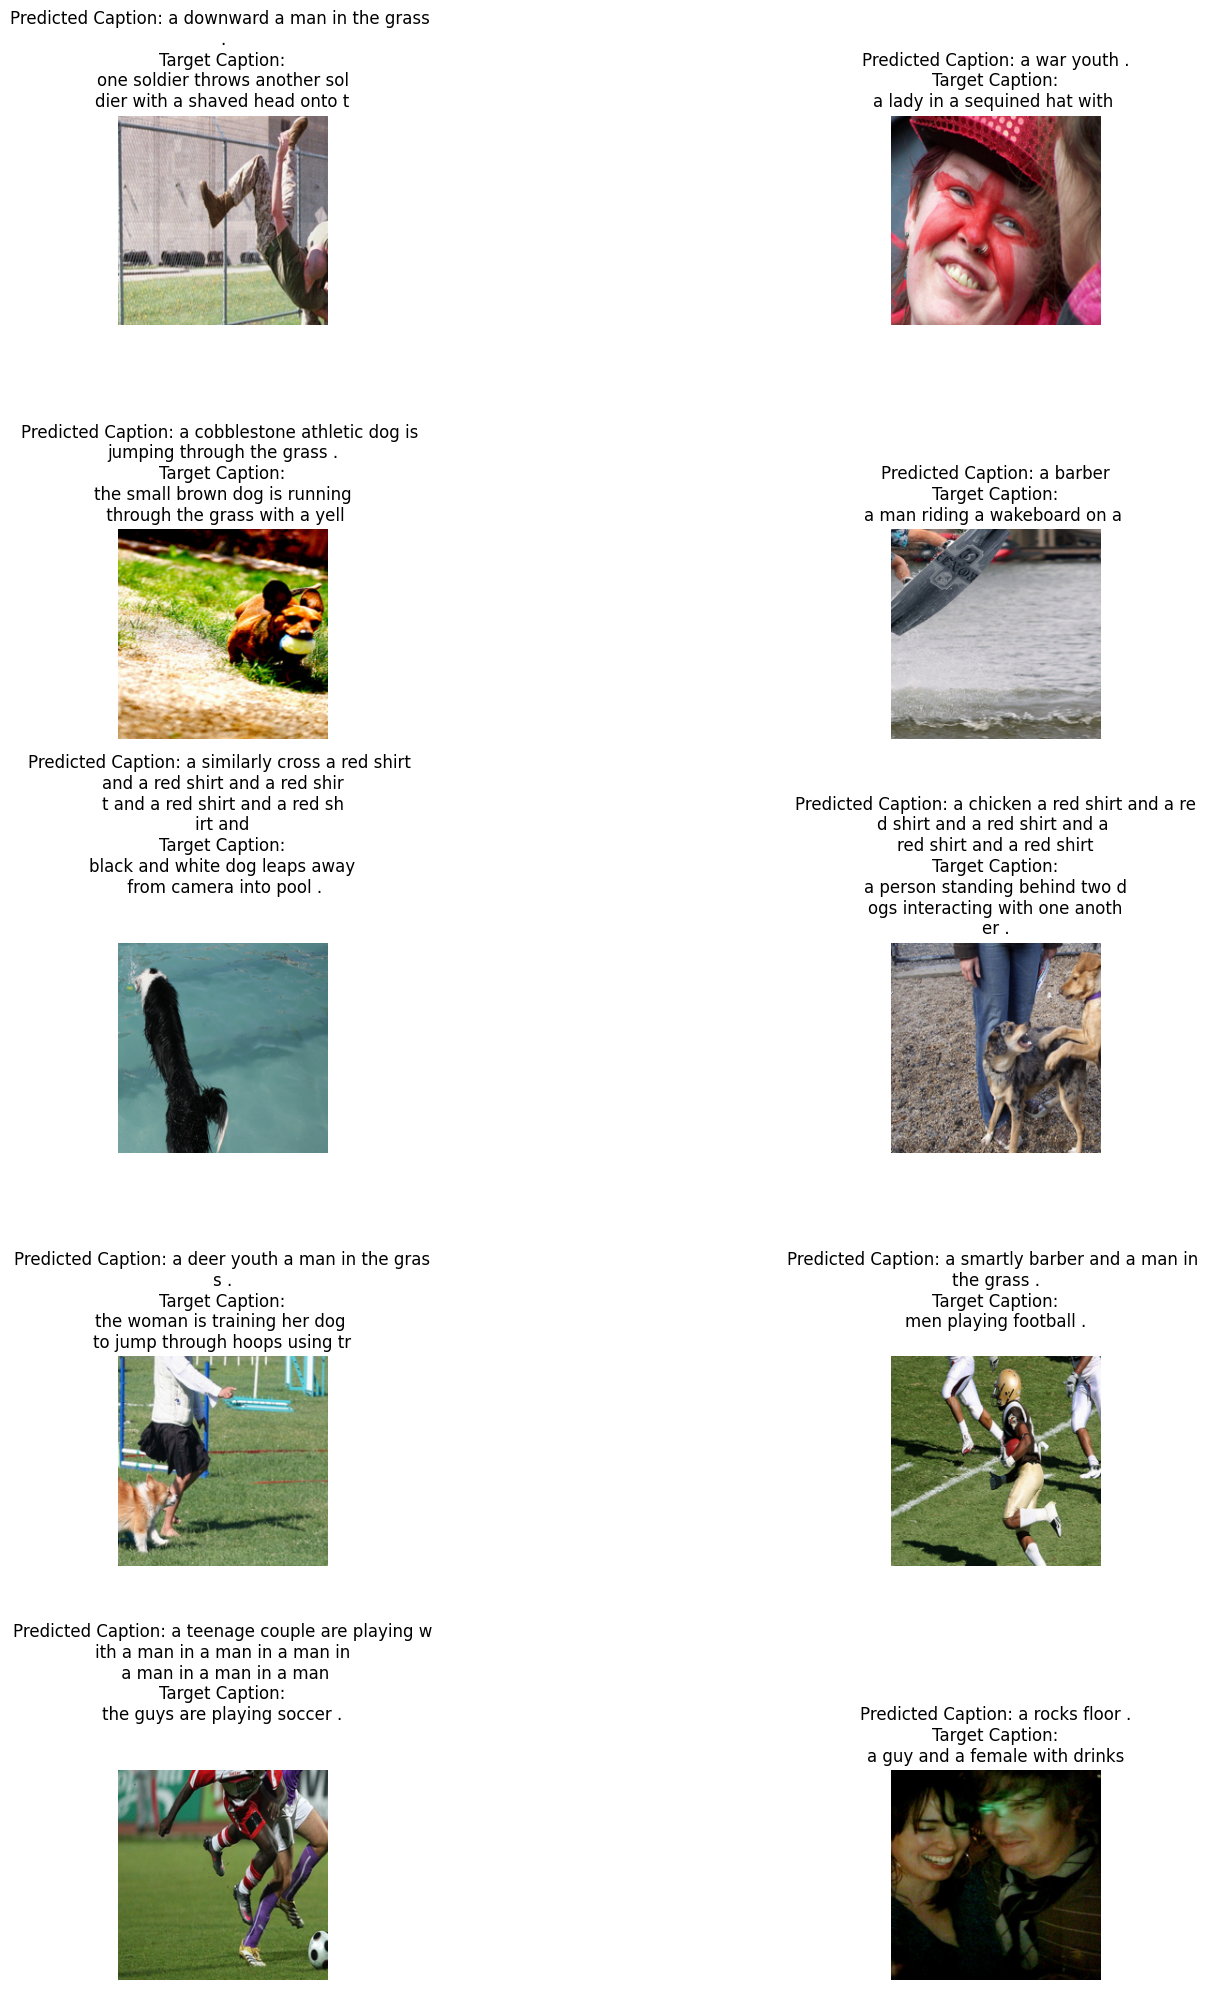

In [16]:
def denormalize(image):

    image = image.squeeze(0).permute(1, 2, 0)
    image = image.cpu().numpy()
    mean = np.array([0.470, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    mean = mean[ np.newaxis, np.newaxis,:]
    std = std[np.newaxis, np.newaxis, :]
    denormalized_image = (image * std) + mean
    denormalized_image = np.clip(denormalized_image, 0, 1)
    return denormalized_image

def sentencer(tokens):
    in_between = False
    extracted_words = []

    for token in tokens:
        if token == '<SOS>':
            in_between = True
        elif token == '<EOS>':
            break
        elif token != '<PAD>' and in_between:
            extracted_words.append(token)

    return " ".join(extracted_words)

def test():
    model.eval()

    num_images = 10
    num_columns = 2
    fig, axs = plt.subplots(num_images // num_columns, num_columns, figsize=(20, 20))


    for idx, (image, caption) in enumerate(test_loader):
        if idx >= num_images:
            break
        row = idx // 2  # Calculate the row index (divided by 2 for 2 columns)
        col = idx % 2
        image = image.to(device)
        caption = caption.to(device)
        pred_caption = model.caption_image(image, dataset.vocab)

        caption = caption.squeeze(1)
        caption_sen = [dataset.vocab.itos[word.item()] for word in caption]
        pred_cap_sentence = sentencer(pred_caption)
        target_cap_sentence = sentencer(caption_sen)
        print(f'Target: {target_cap_sentence}')
        print(f'Pred: {pred_cap_sentence}\n')

        image_np = denormalize(image)

        caption_lines = [pred_cap_sentence[j:j + 30] for j in range(0, len(pred_cap_sentence), 30)]
        target_lines = [target_cap_sentence[j:j + 30] for j in range(0, len(pred_cap_sentence), 30)]
        formatted_caption = '\n'.join(caption_lines)
        formatted_target_caption = '\n'.join(target_lines)

        axs[row, col].imshow(image_np)
        axs[row, col].axis('off')
        axs[row, col].set_title(f'Predicted Caption: {formatted_caption}\nTarget Caption:\n{formatted_target_caption}')

    plt.tight_layout()
    plt.show()

test()
    

In [ ]:
dataset.vocab.stoi['shirt']

131